# Quality assessment Notebook for realism of quasars template.

To-do for this notebook:
    - modified the emission lines in SIMQSO.
    - compute the EMPCA for mocks and data.
    - look the difference between the first eigenvectors for mocks and data.
    - look the difference between mean spectrum for data and mocks.
    - look the difference between mean continuum for mocks and data.
    - look the standard deviation for mocks and data from mean continuum.
    
Conclusion:
    - How do the spectra change with magnitude bins?
    - How do the spectra change with redshift bins? 

# Import the modules

In [1]:
import numpy as np
import scipy as sp
import fitsio
import matplotlib.pyplot as plt
from desispec.interpolation import resample_flux
from desitarget.targetmask import desi_mask
import desispec.io
import sys
from collections import defaultdict

sys.path.append('/global/homes/r/rodcn25/PCA/empca/')
import empca
%pylab inline
%matplotlib inline

Populating the interactive namespace from numpy and matplotlib


# Mocks

Let me start by analysing the SIMQSO mocks from quickquasars. At the moment I only produce 991 spectra with a exposure time of 4000. 

The changes in SIMQSO are:
\begin{eqnarray}
('scaleEWs',&& \{'LyAb':1.1,'LyAn':1.1,\\
            && 'CIVb':0.75,'CIVn':0.75,\hspace{3cm}DEFAULT\\
            && 'CIII]b':0.8,'CIII]n':0.8,\\
            && 'MgIIb':0.8,'MgIIn':0.8\})
\end{eqnarray}

Change:
\begin{eqnarray}
('scaleEWs',&&\{'LyB':1.34,\\
            && 'ArI':0.7,\\
            && 'FeIII:UV1':0.31,\\
            && 'CIII*':0.65,\\
            && 'LyAb':1.1,'LyAn':1.1,\\
            && 'NV':2.6,\\
            && 'SiII':0.9,\\
            && 'OI':1.5,\\
            && 'CII':0.45,\\
            && 'SiIV+OIV]':0.92,\\
            && 'CIVb':0.75,'CIVn':0.75,\\
            && 'CIII]b':0.8,'CIII]n':0.8,\\
            && 'MgIIb':0.8,'MgIIn':0.8\})
\end{eqnarray}

Maybe NV must be changed, because here there is a effect of the metals.

In [3]:
###### Get the mocks
mock={} 
#mck['base'] = '/project/projectdirs/desi/users/alxogm/desi/rodrigo/quick_simqso/' #there are a lot of pixels.
mock['base'] = '/global/cscratch1/sd/rodcn25/lya/'
mock['modified'] = mock['base']+'quick-runs/quick-simqso-0.2/test-0/spectra-16/1/137/spectra-16-137.fits'
MG = fitsio.FITS(mock['modified'])

Read the spectra and zbest files.

In [4]:
specobj= desispec.io.read_spectra(mock['modified']) # spectra file.
zfilename = mock['modified'].replace('spectra-16-137.fits', 'zbest-16-137.fits') 
zs = fitsio.read(zfilename) # zbest file.

Let's match these quasar targets to the redshift file on TARGETID (which is intended to be unique) to extract their best-fit redshifts from redrock  and match with targets the spectra file.

In [5]:
qsos = np.where(specobj.fibermap["DESI_TARGET"] & desi_mask["QSO"])[0]
fm = fitsio.read(mock['modified'],'FIBERMAP')
dd = defaultdict(list)
for index, item in enumerate(zs["TARGETID"]):
    dd[item].append(index)
zqsos = [index for item in fm[qsos]["TARGETID"] for index in dd[item] if item in dd]

look the result:

In [6]:
zs[zqsos]["TARGETID"][0:7], fm[qsos]["TARGETID"][0:7]

(array([80105496, 80105498, 80106009, 80106186, 80106669, 80107360, 80108052]),
 array([80105496, 80105498, 80106009, 80106186, 80106669, 80107360, 80108052]))

Let's need to put the spectra in the rest frame.

In [7]:
qsoid = np.where(zs[zqsos]["SPECTYPE"] == b'QSO')[0]
wavem = specobj.wave
fluxm = specobj.flux
brf = []
rrf = []
zrf = []
for i in range(len(qsoid)):
    spectype = zs[zqsos[qsoid[i]]]["SPECTYPE"].decode('utf-8')
    z = zs[zqsos[qsoid[i]]]["Z"]
    brf.append(wavem['b']/(1+z))
    rrf.append(wavem['r']/(1+z))
    zrf.append(wavem['z']/(1+z))
b_r_f = np.vstack(brf)
r_r_f = np.vstack(rrf)
z_r_f = np.vstack(zrf)

Let's me remove the colorcut of the spectra.

In [9]:
ivarm = specobj.ivar
qsoivars = []
qsofluxs = []
for l in range(len(b_r_f)):
    qsoflux = []
    qsoivar = []
    for i in range(len(b_r_f[l])):
        qsoflux.append(fluxm['b'][l][i])
        qsoivar.append(ivarm['b'][l][i])
    for j in range(len(r_r_f[l])):
        if r_r_f[l][j]>np.max(b_r_f[l]):
            qsoflux.append(fluxm['r'][l][j])
            qsoivar.append(ivarm['r'][l][j])
    for k in range(len(z_r_f[l])):
        if z_r_f[l][k]>np.max(r_r_f[l]):
            qsoflux.append(fluxm['z'][l][k])
            qsoivar.append(ivarm['z'][l][k])
    qsofluxs.append(qsoflux)
    qsoivars.append(qsoivar)
    
qsofluxss = np.vstack(qsofluxs)
qsoivarss = np.vstack(qsoivars)

In [12]:
waves = []
for i in range(len(b_r_f)):
    dw = b_r_f[i][1]-b_r_f[i][0]
    new_wave = np.arange(np.min(b_r_f[i]),np.max(z_r_f[i]),dw)
    waves.append(new_wave)

wavelength = np.vstack(waves)

new wavelength.

In [10]:
CRVAL1 = 2.6534
CDELT1 = 0.0001
NBLL   = 13637
wwave = 10**(CRVAL1+sp.arange(NBLL)*CDELT1)

# EMPCA for mocks

In [15]:
pcafluxm  = sp.zeros((len(qsofluxss), wwave.size))
pcaivarm  = sp.zeros((len(qsofluxss), wwave.size))

for i in range(len(qsofluxss)):
    pcafluxm[i], pcaivarm[i] = resample_flux(wwave,wavelength[i],qsofluxss[i],qsoivarss[i]) # interpolation
    
pcaivarm[pcaivarm<0.] = 0              #
w = sp.sum(pcaivarm,axis=0)>0.         #
wwave = wwave[w]                       # For the noise.
pcafluxm = pcafluxm[:,w]               #
pcaivarm = pcaivarm[:,w]               #
pcaivarm[pcaivarm>100.] = 100.           #

Before calculate EMPCA, we need to calculate the mean spectrum and subtract it of the spectra, such that the eigenvectors represent the principal variations of the spectra with respect to that mean spectrum.

In [17]:
mock_mean_spec = sp.average(pcafluxm,weights=pcaivarm,axis=0)
for i in range(len(qsofluxss)):       #
    w = pcaivarm[i]>0.        # subtracting the mean for each spectrum
    pcafluxm[i,w] -= mock_mean_spec[w]

Here start the EMPCA decomposition with 10 principal components.

In [18]:
mmodel = empca.empca(pcafluxm, weights=pcaivarm, niter=10, nvec=10)

       iter        R2             rchi2
EMPCA  1/10       0.01491804     81.58214194
EMPCA  2/10       0.91662213      5.40887950
EMPCA  3/10       0.96184456      3.70025308
EMPCA  4/10       0.98000361      1.38702126
EMPCA  5/10       0.98265262      1.07236410
EMPCA  6/10       0.98370505      1.00177710
EMPCA  7/10       0.98477464      0.95352441
EMPCA  8/10       0.98490971      0.94404842
EMPCA  9/10       0.98483633      0.94009493
EMPCA 10/10       0.98470976      0.94612708
R2: 0.985368399404


Let's save the data.

In [20]:
from astropy.io import fits
from astropy.table import Table,Column
colum_data1 = [('wavelength','f8'),('mean spectrum','f8')]#,('std spectrum','f8')]
data1 = Table(np.zeros(len(wwave),dtype=colum_data1))
data1['wavelength'][:]=wwave
data1['mean spectrum'][:]=mock_mean_spec
#data1['std spectrum'][:]=std_data

colum_data2=[('model continuum','f8'),('data spectra','f8'),('weights','f8')]
data2=Table(np.zeros((mmodel.data.shape[0],len(wwave)),dtype=colum_data2))
data2['model continuum'][:][:]=mmodel.model
data2['data spectra'][:][:]=mmodel.data
data2['weights'][:][:]=mmodel.weights

colum_data3=[('eigenvec','f8')]
data3=Table(np.zeros((mmodel.eigvec.shape[0],mmodel.eigvec.shape[1]),dtype=colum_data3))
data3['eigenvec'][:][:]=mmodel.eigvec

colum_data4=[('coeff','f8')]
data4=Table(np.zeros((mmodel.coeff.shape[0],mmodel.coeff.shape[1]),dtype=colum_data4))
data4['coeff'][:][:]=mmodel.coeff

hdata1 = fits.convenience.table_to_hdu(data1); hdata1.name='data_wl_mean_std'
hdata2 = fits.convenience.table_to_hdu(data2); hdata2.name='data_model_data_weight'
hdata3 = fits.convenience.table_to_hdu(data3); hdata3.name='data_eigenvectors'
hdata4 = fits.convenience.table_to_hdu(data4); hdata4.name='data_coeff'

hdulist = fits.HDUList([fits.PrimaryHDU(),hdata1,hdata2,hdata3,hdata4])
hdulist.writeto('mock_mod_simqso_qquasar_QA.fits', overwrite=True)

Let's need the continuum of each spectra.

In [21]:
## Get the mocks with EMPCA
mockpca={}
mockpca['base'] = '/global/cscratch1/sd/rodcn25/lya/pruebas_simqso/fits file/'
mockpca['mod'] = mockpca['base']+'mock_mod_simqso_qquasar_QA.fits'
MG = fitsio.FITS(mockpca['mod'])

Let's get the first four eigenvector for reconstruct the MOCKS continuum spectra.
\begin{equation} 
      y(\lambda) = \mu(\lambda) + \sum_{k=1}^{4}c_{k}\phi_{k}(\lambda),
\end{equation}
where $\mu$ is the mean spectrum, $c_{k}$ the coefficients and $\phi_{k}$ are the eigenvectors.

In [22]:
conti_mock = []
for i in range(len(MG[4]['coeff'].read())):
    spectram = []
    for j in range(4):
        spectram.append(MG[4]['coeff'].read()[i][j]*MG[3]['eigenvec'].read()[j])
    spectrasm = np.vstack(spectram)
    specm = np.sum(spectrasm,axis = 0)
    conti_mock += [specm]
continuum_mock = np.vstack(conti_mock)

# Normalize the mock spectra.

In [23]:
dw = 0.28
new_wave = np.arange(600, 3000, dw)
flux_mock = np.zeros((len(continuum_mock), new_wave.size))
for i in range(len(continuum_mock)):
    flux_mock[i] = resample_flux(new_wave, MG[1]['wavelength'].read(), MG[1]['mean spectrum'].read()+continuum_mock[i])

Let me normalize the spectra as follows. 
\begin{equation}
     \int_{1280}^{1500}F(\lambda) d\lambda = 1.
\end{equation}

In [25]:
lmin=1280.0
lmax=1500.0
integral_mock = []
continuum_nor_mock = []
for i in range(len(flux_mock)):
    sum2=0
    for j in range(len(flux_mock[i])):
        if lmin <= new_wave[j] < lmax :
            sum2+=(flux_mock[i][j])*(new_wave[j+1]-new_wave[j])
        elif (new_wave[j] > lmax):
            break
    integral_mock.append(sum2)
    continuum_nor_mock.append(flux_mock[i]/sum2)
contin_mock = np.vstack(continuum_nor_mock)

Finally, let's get the mean continuum (stack) and the standard deviation.

In [26]:
contin_mock = np.vstack(continuum_nor_mock)
stack_mock = np.mean(contin_mock,axis=0)     # mean continuum.
std_stack_mock = np.std(contin_mock,axis=0)  # standard deviation.

# BOSS DR14 data.

Define Lyman series

In [27]:
# Lyman-alpha from eqn 5 of Calura et al. 2012 (Arxiv: 1201.5121)
# Other from eqn 1.1 of Irsic et al. 2013 , (Arxiv: 1307.3403)
# Lyman-limit from abstract of Worseck et al. 2014 (Arxiv: 1402.4154)
Lyman_series = {
    'Lya'     : { 'line':1215.67,  'A':0.0023,          'B':3.64, 'var_evol':3.8 },
    'Lyb'     : { 'line':1025.72,  'A':0.0023/5.2615,   'B':3.64, 'var_evol':3.8 },
    'Ly3'     : { 'line':972.537,  'A':0.0023/14.356,   'B':3.64, 'var_evol':3.8 },
    'Ly4'     : { 'line':949.7431, 'A':0.0023/29.85984, 'B':3.64, 'var_evol':3.8 },
    'Ly5'     : { 'line':937.8035, 'A':0.0023/53.36202, 'B':3.64, 'var_evol':3.8 },
    #'LyLimit' : { 'line':911.8,    'A':0.0023,          'B':3.64, 'var_evol':3.8 },
}

Transmitted flux fraction from Lyman series.

In [28]:
def transmission_Lyman(zObj,lObs):
    '''Calculate the transmitted flux fraction from the Lyman series
    This returns the transmitted flux fraction:
        1 -> everything is transmitted (medium is transparent)
        0 -> nothing is transmitted (medium is opaque)
    Args:
        zObj (float): Redshift of object
        lObs (array of float): wavelength grid
    Returns:
        array of float: transmitted flux fraction
    '''

    lRF = lObs/(1.+zObj)
    T   = sp.ones(lObs.size)

    for l in list(Lyman_series.keys()):
        w      = lRF<Lyman_series[l]['line']
        zpix   = lObs[w]/Lyman_series[l]['line']-1.
        tauEff = Lyman_series[l]['A']*(1.+zpix)**Lyman_series[l]['B']
        T[w]  *= sp.exp(-tauEff)

    return T

Let's read the data and only choose the quasars. 

In [29]:
def plot_spplate(path_to_data,plate,mjd,fiber):

    ###
    path = path_to_data+str(plate)+'/spPlate-' +str(plate)+'-'+str(mjd)+'.fits'

    cat = fitsio.FITS(path)
    psflux = cat[0].read()
    psivar = cat[1].read()
    end  = cat[2].read()
    h    = cat[4].read_header()
    fid = cat[5].read()
    cat.close()

    pswave = h['CRVAL1'] + h['CD1_1']*sp.arange(h['NAXIS1'])
    if h['DC-FLAG']:
        pswave = 10**pswave

    ###
    cut = (psivar[fiber-1,:]>0.) & (end[fiber-1,:]==0)
    qsoid = np.where(fid['OBJTYPE'][:] == b'QSO             ')[0]#I only choose the QSO's. 
    if (fiber-1) in qsoid:
        pswave = pswave[cut]
        psflux = psflux[fiber-1,:][cut]
        psivar = psivar[fiber-1,:][cut]
    else: 
        #print('No QSO')
        pswave = np.array([0])
        psflux = np.array([0])
        psivar = np.array([0])

    return pswave, psflux, psivar

Let's remove the sky lines.

In [30]:
def lines_list(path):

    lines = []
    fileLines = open(path)
    for l in fileLines:
        l = l.split()
        if l[0]=='#': continue
        lines += [ [float(l[1]),float(l[2])] ]
    fileLines.close()
    lines = sp.asarray(lines)

    return lines

Let's get only the quasars spectra with ly-$\alpha$, CIV (or both) peaks. 

In [32]:
def get_pca():

    ### Parameters
    path_spec      = '/project/projectdirs/cosmo/data/sdss/dr14/eboss/spectro/redux/v5_10_0/'
    path_drq       = '/global/cscratch1/sd/rodcn25/lya/boss_data/DR14Q_v4_4.fits'
    path_lines     = '/global/homes/r/rodcn25/PCA/dr14-line-sky-mask.txt'
    nbObj  = 10000
    CRVAL1 = 2.6534
    CDELT1 = 0.0001
    NBLL   = 13637

    ### Get lines to veto
    lines = lines_list(path_lines)

    ### Get list qso
    data      = fitsio.FITS(path_drq)
    w  = sp.ones(data[1]['PLATE'][:].size).astype(bool)
    print('INFO: init              : ', w.sum())
    w &= data[1]['THING_ID'][:]>0.
    print('INFO: removed THID>=0   : ', w.sum())
    #print('INFO: removed THID<=0   : ', w.sum())
    w &= data[1]['Z_PCA'][:]>0.
    print('INFO: removed zvi>=0.   : ', w.sum())
    #print('INFO: removed zvi<=0.   : ', w.sum())
    plate   = data[1]['PLATE'][:][w]
    mjd     = data[1]['MJD'][:][w]
    fiberid = data[1]['FIBERID'][:][w]
    zvi     = data[1]['Z_PCA'][:][w]
    data.close()
    nsamples=100
    ### Random number of object
    sp.random.seed(10)
    listQSO = sp.arange(plate.size)
    randSelec = sp.array([])
    for i in sp.arange(0.,10.,0.1):
        w = (zvi>=i) & (zvi<i+0.1)
        if listQSO[w].size==0: continue
        r = sp.random.choice(listQSO[w], size=min(listQSO[w].size,nsamples), replace=False)
        randSelec = sp.append(randSelec,r)
    #randSelec = sp.append(randSelec,sp.random.choice(listQSO, size=nbObj, replace=False))
    randSelec = sp.unique(randSelec)
    randSelec = randSelec.astype(int)
    nbObj = randSelec.size
    print('INFO: size = ', nbObj)


    ### Get spectra
    ttwave = []
    ttflux = []
    ttivar = []
    for i in range(nbObj)[:900]: 
        #if i%10==0: print(i)
        r = randSelec[i]

        TMPwave, TMPflux, TMPivar = plot_spplate(path_spec,plate=plate[r],mjd=mjd[r],fiber=fiberid[r])
        TMPwaveRF = TMPwave/(1.+zvi[r])
        if TMPwave.size<500:
            #print('INFO: removing size<10: {}'.format(TMPwave.size))
            continue

        ### Remove sky lines and CCD edge
        w = sp.ones_like(TMPwave).astype(bool)
        for l in lines:
            w &= (TMPwave<l[0]) | (TMPwave>l[1])
        w &= TMPwave>3600.
        w &= TMPwave<7235.
        TMPwave = TMPwave[w]
        TMPflux = TMPflux[w]
        TMPivar = TMPivar[w]
        TMPwaveRF = TMPwaveRF[w]
        if TMPwave.size<500:
            #print('INFO: removing size<10: {}'.format(TMPwave.size))
            continue

        ### Correct for Lyman
        T = transmission_Lyman(zvi[r],TMPwave)
        TMPflux /= T
        TMPivar *= T**2

        ### Rescale by median
        #mid = sp.median(TMPflux)
        #if mid<=0.:
            #print('INFO: removing med<=0: {}'.format(mid))
        #    continue
        #TMPflux /= mid
        #TMPivar *= mid**2

        ### Store
        ttwave += [TMPwaveRF]
        ttflux += [TMPflux]
        ttivar += [TMPivar]
        
    rwave = []
    rflux = []
    rivar = []
    for j in range(len(ttflux)):
        if ttwave[j].any() and ttflux[j].any() == False:
            continue
        elif ttwave[j].any() and ttflux[j].any() == True:
            rwave += [ttwave[j]]
            rflux += [ttflux[j]]
            rivar += [ttivar[j]]
            
    rrwave = []
    rrflux = []
    rrivar = []
    for k in range(len(rflux)):
        wl = rwave[k]
        fl = rflux[k]
        iv = rivar[k]
        maskk = (wl>1250.0) & (wl<1500.0)
        if fl[maskk].any() == 0. :
            continue
        else:
            rrwave += [wl]
            rrflux += [fl]
            rrivar += [iv]

    nbObj = len(rrwave)
    print('INFO: size = ', nbObj)

    ###
    pcawave    = 10**(CRVAL1+sp.arange(NBLL)*CDELT1)
    pcaflux    = sp.zeros((nbObj, pcawave.size))
    pcaivar    = sp.zeros((nbObj, pcawave.size))
    ### On same grid
    for i in range(nbObj):
        pcaflux[i],pcaivar[i] = resample_flux(pcawave, rrwave[i], rrflux[i], rrivar[i])
    pcaivar[pcaivar<0.] = 0.
    ### Remove if all measured bins are zero
    w    = sp.sum(pcaivar,axis=0)>0.
    pcawave = pcawave[w]
    pcaflux = pcaflux[:,w]
    pcaivar = pcaivar[:,w]
    ### Cap the ivar
    pcaivar[pcaivar>100.] = 100.
    
    #mskaa = (pcawave>1230) & (pcawave<1600)
    #for i in range(nbObj):
    #    mid = np.mean(pcaflux[i][mskaa])
    #    if mid<=0:
    #        continue
    #    pcaflux[i] /= mid
    #    pcaivar[i] *= mid**2

    ### Get the mean
    data_meanspec = sp.average(pcaflux,weights=pcaivar,axis=0) # Here, I get the mean spectrum.
    for i in range(nbObj):       #
        w = pcaivar[i]>0.        # subtracting the mean for each spectrum
        pcaflux[i,w] -= data_meanspec[w] #

    ### PCA
    print('INFO: Starting EMPCA')
    dmodel = empca.empca(pcaflux, weights=pcaivar, niter=10, nvec=10)
    #for i in range(dmodel.coeff.shape[0]):
    #    dmodel.coeff[i] /= sp.linalg.norm(dmodel.coeff[i])
        
    return dmodel, pcawave, pcaflux, pcaivar, data_meanspec

Let's get the mean spectrum od the BOSS data and the EMPCA decomposition with 10 principal components.

In [33]:
model_empca, wave_empca, flux_empca, ivar_empca, meanspec_data=get_pca()

INFO: init              :  526356
INFO: removed THID>=0   :  446137
INFO: removed zvi>=0.   :  444976
INFO: size =  4801
INFO: size =  433
INFO: Starting EMPCA
       iter        R2             rchi2
EMPCA  1/10       0.04546865     20.26149797
EMPCA  2/10       0.70344155      6.00918650
EMPCA  3/10       0.80074825      4.42048660
EMPCA  4/10       0.85666468      2.56318913
EMPCA  5/10       0.87036545      2.19628976
EMPCA  6/10       0.84580018      2.63209696
EMPCA  7/10       0.86125063      2.23038573
EMPCA  8/10       0.87834671      1.83032749
EMPCA  9/10       0.88093115      1.76954252
EMPCA 10/10       0.88464410      1.71348416
R2: 0.89110947205


Only 433 spectra were found. R2, return fraction of data variance which is explained by the first nvec vectors, in this case are 10 eigenvectors.

Save the data.

In [35]:
from astropy.table import Table,Column
colum_data1 = [('wavelength','f8'),('mean spectrum','f8')]#,('std spectrum','f8')]
data1 = Table(np.zeros(len(wave_empca),dtype=colum_data1))
data1['wavelength'][:]=wave_empca
data1['mean spectrum'][:]=meanspec_data
#data1['std spectrum'][:]=std_data

colum_data2=[('model continuum','f8'),('data spectra','f8'),('weights','f8')]
data2=Table(np.zeros((model_empca.data.shape[0],len(wave_empca)),dtype=colum_data2))
data2['model continuum'][:][:]=model_empca.model
data2['data spectra'][:][:]=model_empca.data
data2['weights'][:][:]=model_empca.weights

colum_data3=[('eigenvec','f8')]
data3=Table(np.zeros((model_empca.eigvec.shape[0],model_empca.eigvec.shape[1]),dtype=colum_data3))
data3['eigenvec'][:][:]=model_empca.eigvec

colum_data4=[('coeff','f8')]
data4=Table(np.zeros((model_empca.coeff.shape[0],model_empca.coeff.shape[1]),dtype=colum_data4))
data4['coeff'][:][:]=model_empca.coeff

hdata1 = fits.convenience.table_to_hdu(data1); hdata1.name='data_wl_mean_std'
hdata2 = fits.convenience.table_to_hdu(data2); hdata2.name='data_model_data_weight'
hdata3 = fits.convenience.table_to_hdu(data3); hdata3.name='data_eigenvectors'
hdata4 = fits.convenience.table_to_hdu(data4); hdata4.name='data_coeff'

hdulist = fits.HDUList([fits.PrimaryHDU(),hdata1,hdata2,hdata3,hdata4])
hdulist.writeto('data_dr14_QA.fits', overwrite=True)

Let's need the continuum of each spectra.

In [36]:
## Get the data of BOSS DR14
data = {}
data['spectra'] = mockpca['base']+'data_dr14_QA.fits'
DS2 = fitsio.FITS(data['spectra'])

In [37]:
conti_boss = []
for i in range(len(DS2[4]['coeff'].read())):
    spectra = []
    for j in range(4):
        spectra.append(DS2[4]['coeff'].read()[i][j]*DS2[3]['eigenvec'].read()[j])
    spectras = np.vstack(spectra)
    spec = np.sum(spectras,axis = 0)
    conti_boss += [spec]
continuum_boss = np.vstack(conti_boss)

# Normalize the BOSS continuum spectra.

In [38]:
qsofluxd = np.zeros((len(continuum_boss), new_wave.size))
for i in range(len(continuum_boss)):
    qsofluxd[i] = resample_flux(new_wave,DS2[1]['wavelength'].read(),DS2[1]['mean spectrum'].read()+continuum_boss[i])

Let's normalize the spectra with the same criteria as the mocks.

In [39]:
integral_boss = []
continuum_nor_boss = []
for i in range(len(continuum_boss)):
    sum1=0
    for j in range(len(continuum_boss[i])):
        if lmin <= new_wave[j] < lmax :
            sum1+=(qsofluxd[i][j])*(new_wave[j+1]-new_wave[j])
        elif (new_wave[j] > lmax):
            break
    integral_boss.append(sum1)
    continuum_nor_boss.append((qsofluxd[i])/sum1)
contin_boss = np.vstack(continuum_nor_boss)

Let's get the mean continuum and the standard deviations for the DR14 data.

In [40]:
stack_boss = np.mean(contin_boss,axis=0)
std_stack_boss = np.std(contin_boss,axis=0)

# Comparison.

First, let's look the EMPCA fitting.

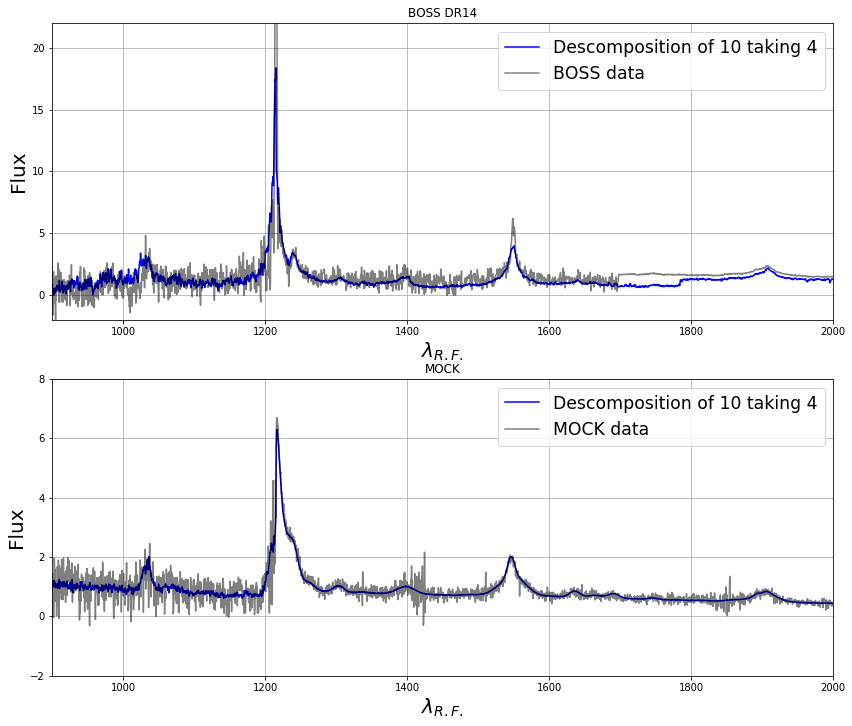

In [49]:
plt.figure(figsize=(14,12))
plt.subplot(2,1,1)
plt.title('BOSS DR14')
plt.plot(DS2[1]['wavelength'].read(),DS2[1]['mean spectrum'].read()+continuum_boss[2],label='Descomposition of 10 taking 4',color='b')
#plt.plot(DS2[1]['wavelength'].read(),DS2[1]['mean spectrum'].read()+DS2[2]['model continuum'].read()[125],color='g',label='Model continuum 10 eigenvectors')#,alpha=0.5)
plt.plot(DS2[1]['wavelength'].read(),DS2[1]['mean spectrum'].read()+DS2[2]['data spectra'].read()[2],label='BOSS data',color='k',alpha=0.5)
plt.xlim(900,2000)
plt.ylim(-2,22)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('Flux', fontsize = 20)
#plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
plt.legend(fontsize='xx-large')
plt.grid()

plt.subplot(2,1,2)
plt.title('MOCK')
plt.plot(MG[1]['wavelength'].read(),MG[1]['mean spectrum'].read()+continuum_mock[0],label='Descomposition of 10 taking 4',color='b')
#plt.plot(DS2[1]['wavelength'].read(),DS2[1]['mean spectrum'].read()+DS2[2]['model continuum'].read()[125],color='g',label='Model continuum 10 eigenvectors')#,alpha=0.5)
plt.plot(MG[1]['wavelength'].read(),MG[1]['mean spectrum'].read()+MG[2]['data spectra'].read()[0],label='MOCK data',color='k',alpha=0.5)
plt.xlim(900,2000)
plt.ylim(-2,8)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('Flux', fontsize = 20)
#plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
plt.legend(fontsize='xx-large')
plt.grid()

Let's comparison the mean spectrum.

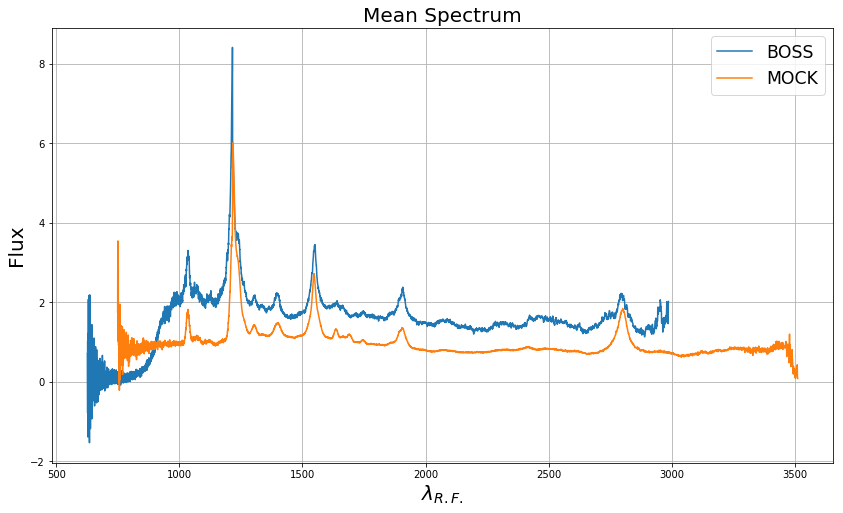

In [50]:
plt.figure(figsize=(14,8))
plt.title('Mean Spectrum',fontsize = 20)
plt.plot(DS2[1]['wavelength'].read(),DS2[1]['mean spectrum'].read(),label='BOSS')
plt.plot(MG[1]['wavelength'].read(),MG[1]['mean spectrum'].read(),label='MOCK')
#plt.xlim(900,1600)
#plt.ylim(-0.002,0.01)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('Flux', fontsize = 20)
plt.legend(fontsize='xx-large')
plt.grid()

Now, let's look the mean continuum

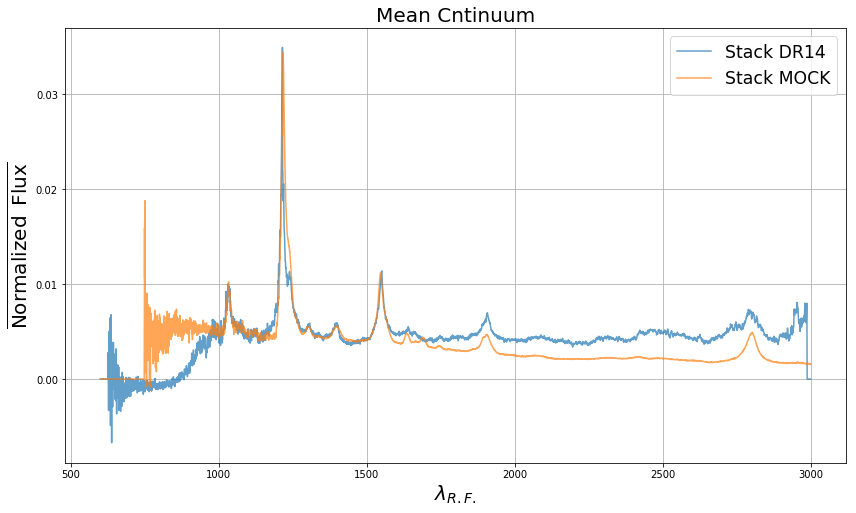

In [53]:
plt.figure(figsize=(14,8))
plt.title('Mean Cntinuum',fontsize = 20)
plt.plot(new_wave,stack_boss,'-', label='Stack DR14',alpha=0.7)
plt.plot(new_wave,stack_mock,'-', label='Stack MOCK',alpha=0.7)
#plt.xlim(900,1600)
#plt.ylim(-0.002,0.01)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('$\mathrm{\overline{Normalized \enspace Flux}}$', fontsize = 20)
plt.legend(fontsize='xx-large')
plt.grid()

We can look that there is a shift in the right side of the mean continuum, but I don't know if it is important for the correlations function.

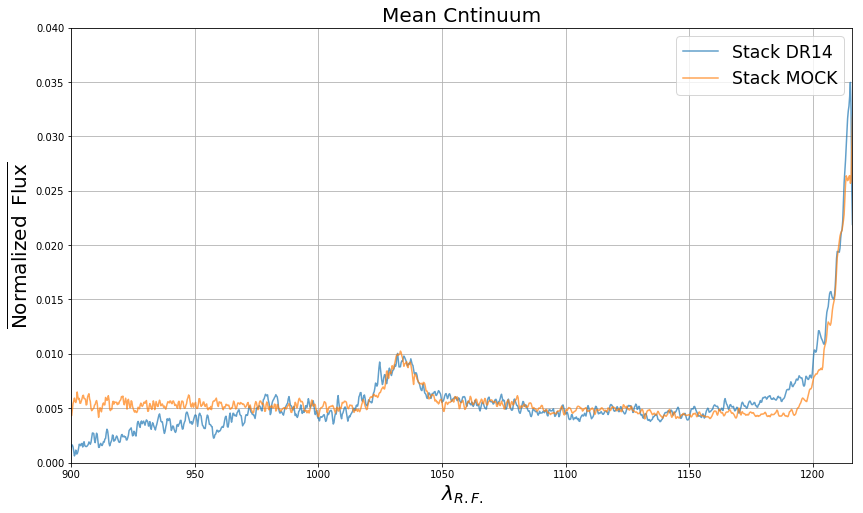

In [55]:
plt.figure(figsize=(14,8))
plt.title('Mean Cntinuum',fontsize = 20)
plt.plot(new_wave,stack_boss,'-', label='Stack DR14',alpha=0.7)
plt.plot(new_wave,stack_mock,'-', label='Stack MOCK',alpha=0.7)
plt.xlim(900,1216)
plt.ylim(0,0.04)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
plt.ylabel('$\mathrm{\overline{Normalized \enspace Flux}}$', fontsize = 20)
plt.legend(fontsize='xx-large')
plt.grid()

Let's comparison the standard deviations.

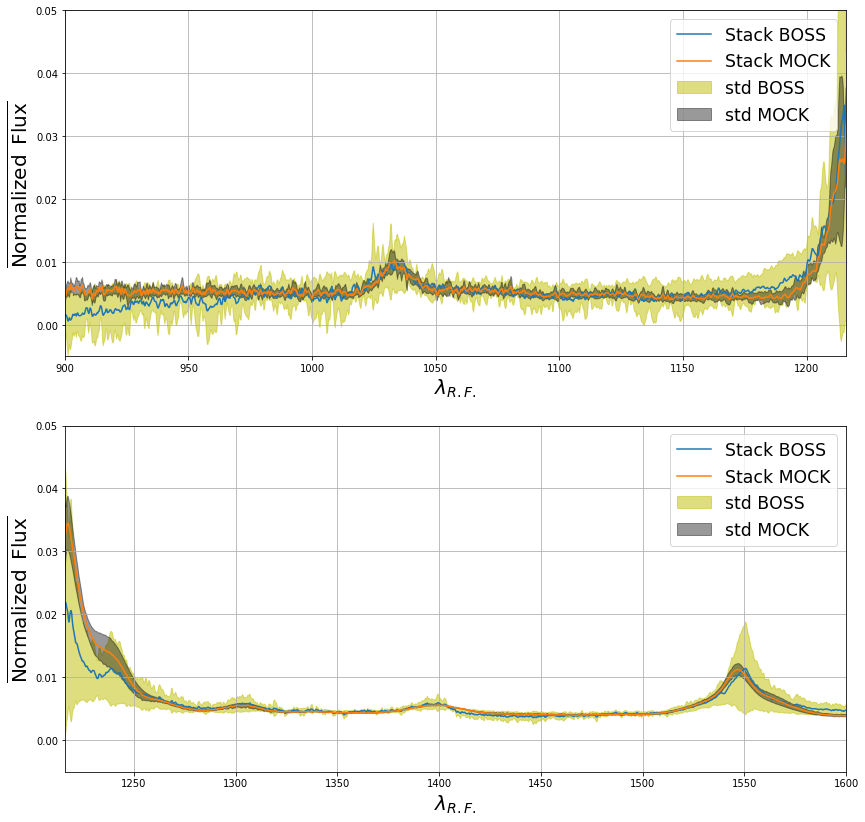

In [54]:
plt.figure(figsize=(14,14))
plt.subplot(2,1,1)
plt.plot(new_wave,stack_boss,'-', label='Stack BOSS')
plt.fill_between(new_wave,stack_boss+std_stack_boss,stack_boss-std_stack_boss, label='std BOSS', color = 'y', alpha=0.5)
plt.plot(new_wave,stack_mock,'-', label='Stack MOCK')
plt.fill_between(new_wave,stack_mock+std_stack_mock,stack_mock-std_stack_mock, label='std MOCK', color = 'k', alpha=0.4)
plt.xlim(900,1216)
plt.ylim(-0.005,0.05)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
#plt.ylabel('Normalized Flux', fontsize = 20)
#axhline(0.0177,color='k',alpha=0.5)
#axhline(0.0022,color='k',alpha=0.5)
plt.ylabel('$\mathrm{\overline{Normalized \enspace Flux}}$', fontsize = 20)
plt.legend(fontsize='xx-large')
plt.grid()

plt.subplot(2,1,2)
plt.plot(new_wave,stack_boss,'-', label='Stack BOSS')
plt.fill_between(new_wave,stack_boss+std_stack_boss,stack_boss-std_stack_boss, label='std BOSS', color = 'y', alpha=0.5)
plt.plot(new_wave,stack_mock,'-', label='Stack MOCK')
plt.fill_between(new_wave,stack_mock+std_stack_mock,stack_mock-std_stack_mock, label='std MOCK', color = 'k', alpha=0.4)
plt.xlim(1216,1600)
plt.ylim(-0.005,0.05)
plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
#plt.ylabel('Normalized Flux', fontsize = 20)
#axhline(0.0177,color='k',alpha=0.5)
#axhline(0.0022,color='k',alpha=0.5)
plt.ylabel('$\mathrm{\overline{Normalized \enspace Flux}}$', fontsize = 20)
plt.legend(fontsize='xx-large')
plt.grid()

Finally, let's comparison the first four eigenvectors.

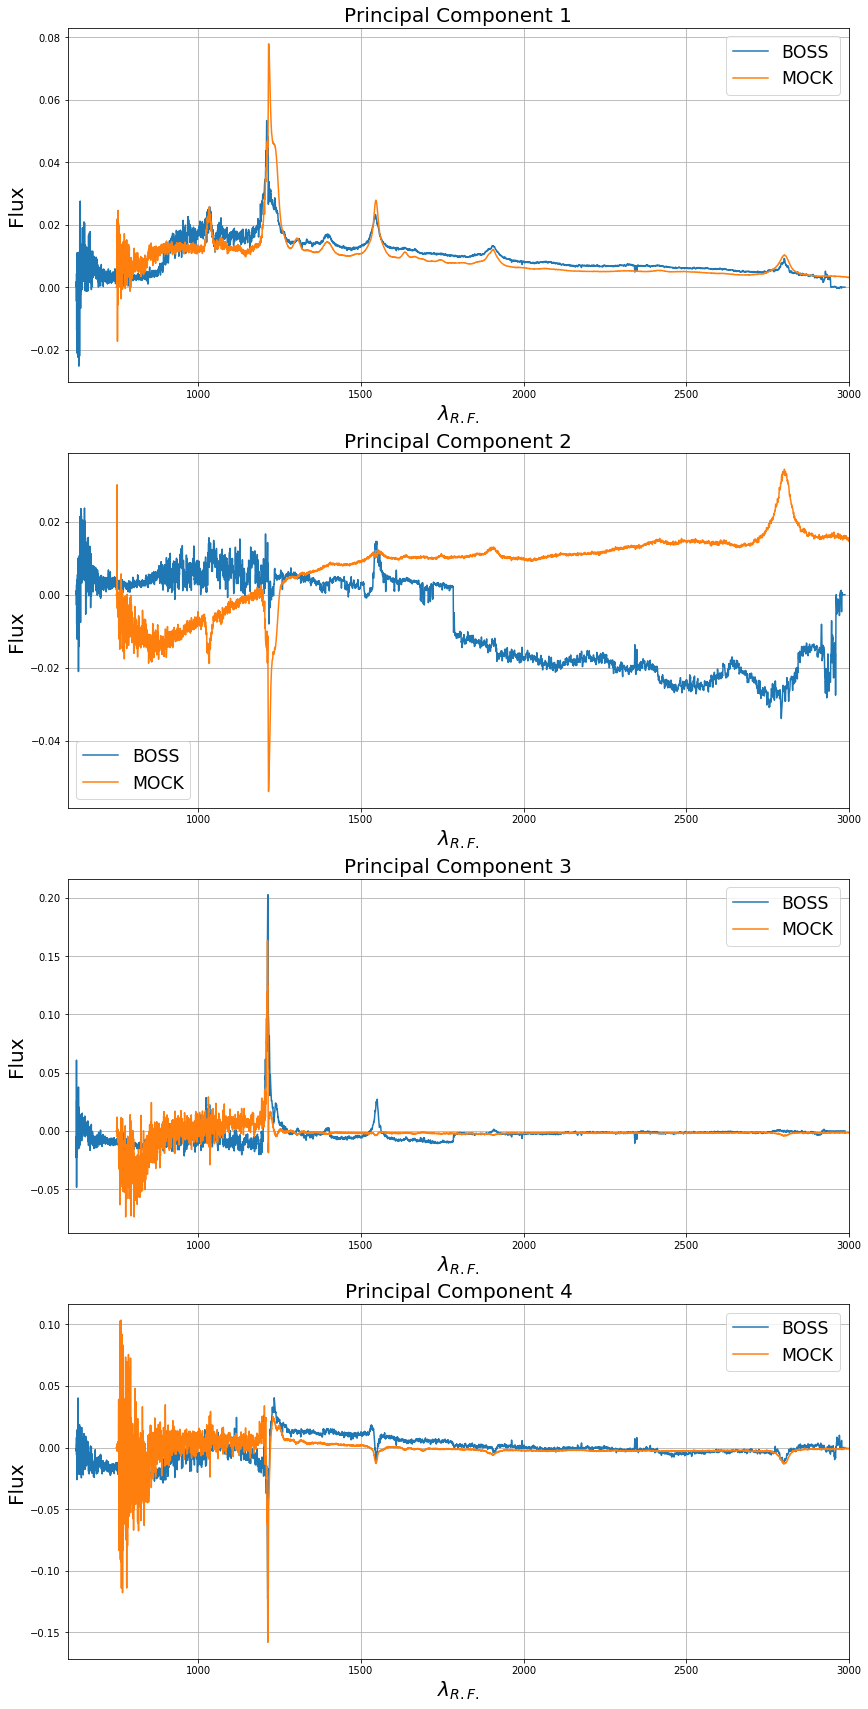

In [62]:
plt.figure(figsize=(14,30))
for i in range(4):
    plt.subplot(4,1,i+1)
    plt.title('Principal Component {}'.format(i+1),fontsize=20)
    plt.plot(DS2[1]['wavelength'].read(),DS2[3]['eigenvec'].read()[i],label='BOSS')
    plt.plot(MG[1]['wavelength'].read(),MG[3]['eigenvec'].read()[i],label='MOCK')
    plt.xlim(600,3000)
    #plt.ylim(-2,10)
    plt.xlabel('$\lambda_{R.F.}$', fontsize = 20)
    plt.ylabel('Flux', fontsize = 20)
    #plt.ylabel('$\mathrm{\overline{Flux}}$', fontsize = 20)
    plt.legend(fontsize='xx-large')
    plt.grid()

We can look that only the second principal component has a import change, this may be due to the difference in the slopes of the spectra. For a better interpretation of the principal components, see http://articles.adsabs.harvard.edu/cgi-bin/nph-iarticle_query?1992ApJ...398..476F&amp;data_type=PDF_HIGH&amp;whole_paper=YES&amp;type=PRINTER&amp;filetype=.pdf